# The Sparks Foundation - Stock Market Prediction using Numerical and Textual Analysis
Task - Create a hybrid model for stock price/performance
prediction using numerical analysis of historical stock prices, and
sentimental analysis of news headlines.

Author - Rubal Bansal

### Import Libraries
Importing all libraries required

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import altair as alt
import statsmodels.api as sm 

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor

from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

### The Data
Reading data in the BSESN.csv & india-news-headlines.csv file into a pandas dataframe.

#### Load Stock Price Data [SENSEX]

In [2]:
hisdf = pd.read_csv("BSESN.csv")
print("Stocks data imported")

hisdf.head()

Stocks data imported


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0


In [3]:
hisdf = hisdf.rename({'Date': 'date'}, axis=1)

In [4]:
hisdf.shape

(252, 7)

In [5]:
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       252 non-null    object 
 1   Open       250 non-null    float64
 2   High       250 non-null    float64
 3   Low        250 non-null    float64
 4   Close      250 non-null    float64
 5   Adj Close  250 non-null    float64
 6   Volume     250 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.9+ KB


#### Load Textual Data [Times of India News Headline]

In [6]:
columns=['Date','Category','News']
ndf = pd.read_csv('india-news-headlines.csv', names=columns)
print("News data imported")

ndf.head()

C:\Users\ASUS\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


News data imported


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [7]:
ndf = ndf.rename({'Date': 'date'}, axis=1)

In [8]:
ndf.shape

(3424068, 3)

In [9]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424068 entries, 0 to 3424067
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   date      object
 1   Category  object
 2   News      object
dtypes: object(3)
memory usage: 78.4+ MB


In [10]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
ndf.head(-5)

,date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3424058,20201231,50 NRIs reach Singhu; offer help to farmers
3424059,20201231,Navjot Singh Sidhu tweets apology; says 'wore ...
3424060,20201231,Azim Premji organisation's name misused to che...
3424061,20201231,Get govt nod to probe officials: MP to agencies


In [11]:
ndf.shape

(3424067, 2)

#### Making the timestamp

In [12]:
ndf["date"] = pd.to_datetime(ndf["date"],format='%Y%m%d')
hisdf["date"] = pd.to_datetime(hisdf["date"],format='%Y-%m-%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 78.4+ MB


#### Group headlines for each day

In [13]:
ndf['News'] = ndf.groupby(['date']).transform(lambda x : ' '.join(x)) 
ndf = ndf.drop_duplicates() 
ndf.reset_index(inplace=True,drop=True)

In [14]:
ndf

,date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [15]:
ndf.shape

(7262, 2)

#### Check for any duplicated values

In [16]:
ndf.isnull().sum()

date    0
News    0
dtype: int64

In [17]:
hisdf.shape

(252, 7)

In [18]:
hisdf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,37804.237375,38071.182859,37422.826992,37745.454117,37745.454117,19134.000000
std,4507.985769,4380.974060,4647.212947,4535.304336,4535.304336,16540.261333
min,26499.810547,27462.869141,25638.900391,25981.240234,25981.240234,0.000000
25%,34369.659179,34779.932618,33975.389648,34257.097656,34257.097656,13125.000000
50%,38489.480469,38750.359375,38234.869140,38425.974610,38425.974610,17000.000000
75%,41179.222656,41376.482422,41023.923828,41135.233399,41135.233399,21075.000000
max,46774.320313,46992.570313,46627.601563,46890.339844,46890.339844,188300.000000


#### Checking for Null values

In [19]:
hisdf.isnull().sum()

date         0
Open         2
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64

In [20]:
len(hisdf)

252

#### Dropping Null values

In [21]:
hisdf.dropna(inplace = True)
len(hisdf)

250

## Exploratory Data Analysis and Visualisation

Text(0, 0.5, 'Volume')

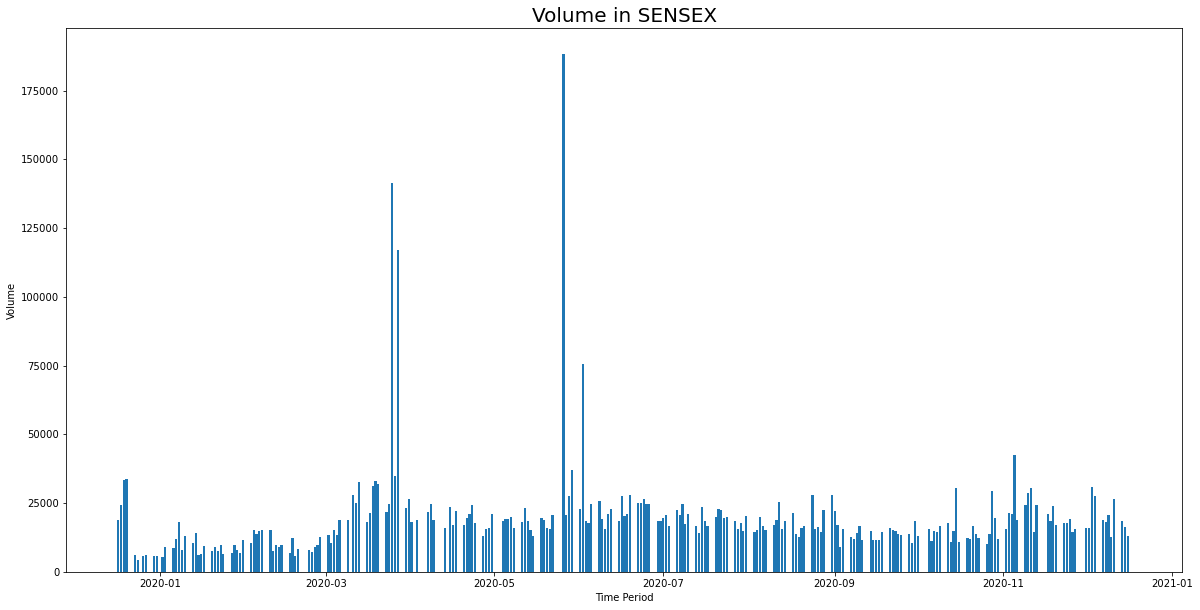

In [22]:
plt.figure(figsize=(20,10))
plt.bar(hisdf["date"],hisdf["Volume"])
plt.title("Volume in SENSEX",fontsize = 20)
plt.xlabel("Time Period")
plt.ylabel("Volume")

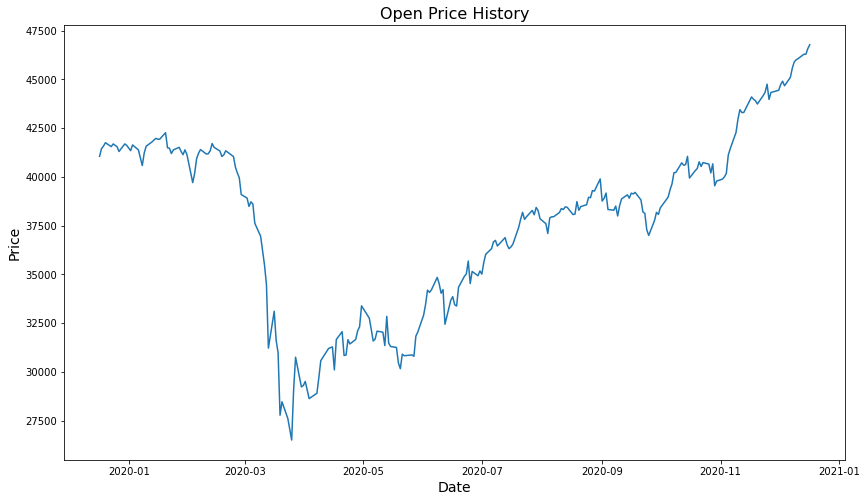

In [23]:
# Open Price History plot
plt.figure(figsize=(14, 8))
plt.plot(hisdf['date'], hisdf['Open'])
plt.title("Open Price History", fontsize = 16)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Price", fontsize = 14)
plt.show()

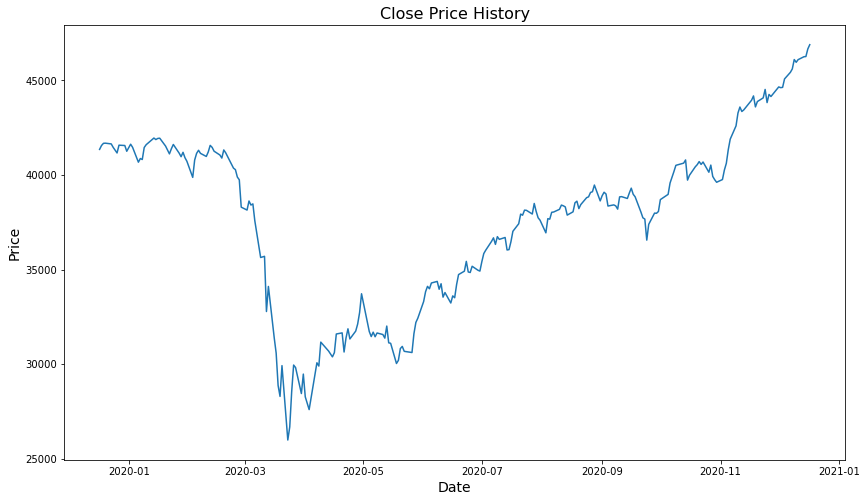

In [24]:
# Close Price History plot
plt.figure(figsize=(14, 8))
plt.plot(hisdf['date'], hisdf['Close'])
plt.title("Close Price History", fontsize = 16)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Price", fontsize = 14)
plt.show()

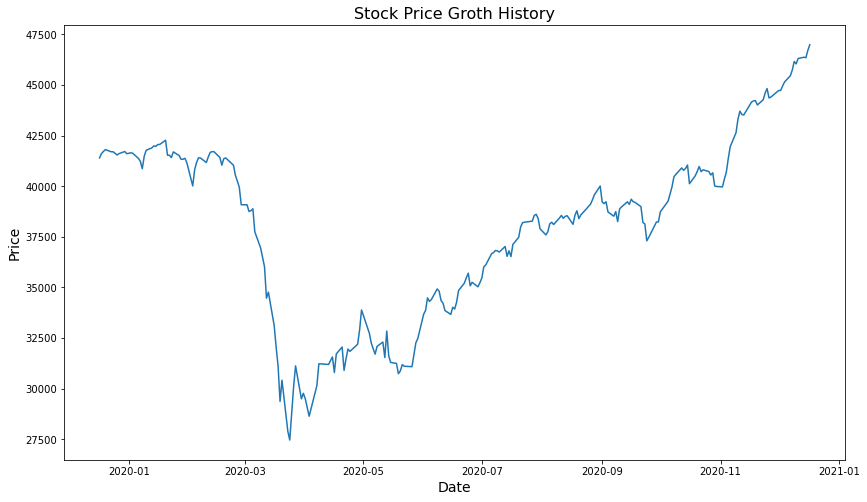

In [25]:
# Stock Price Groth History plot
plt.figure(figsize=(14, 8))
plt.plot(hisdf['date'], hisdf['High'])
plt.title("Stock Price Groth History", fontsize = 16)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Price", fontsize = 14)
plt.show()

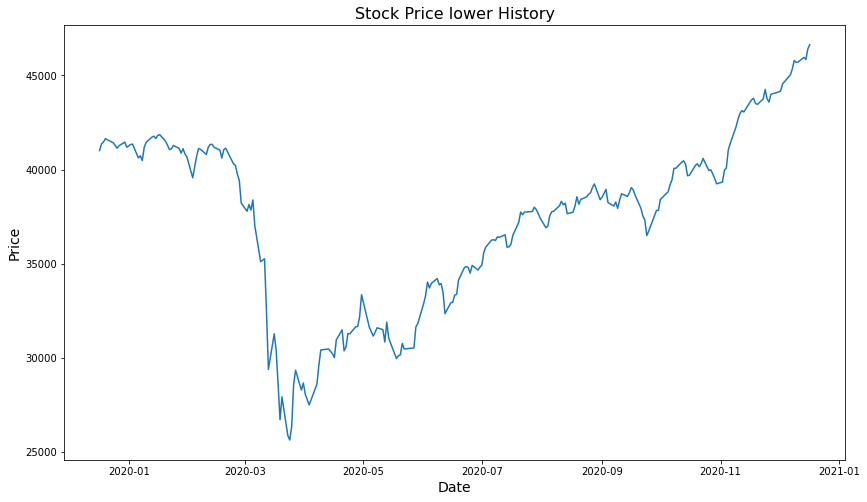

In [26]:
# Stock Price lower History plot
plt.figure(figsize=(14, 8))
plt.plot(hisdf['date'], hisdf['Low'])
plt.title("Stock Price lower History", fontsize = 16)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Price", fontsize = 14)
plt.show()

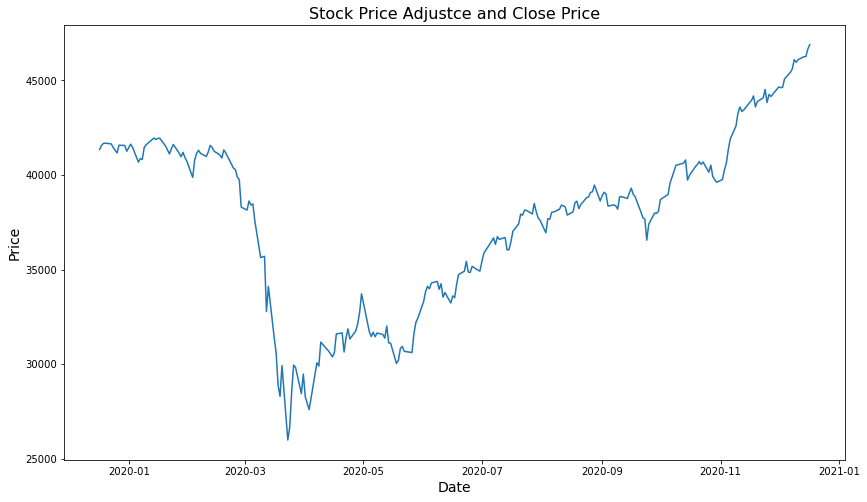

In [27]:
# Stock Price Adjustce and Close Price plot
plt.figure(figsize=(14, 8))
plt.plot(hisdf['date'], hisdf['Adj Close'])
plt.title("Stock Price Adjustce and Close Price", fontsize = 16)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Price", fontsize = 14)
plt.show()

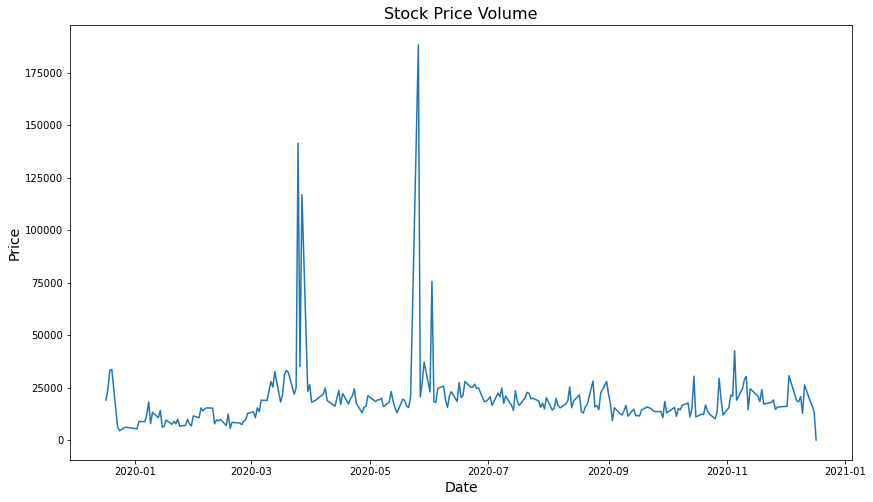

In [28]:
# Stock Price Volume plot
plt.figure(figsize=(14, 8))
plt.plot(hisdf['date'], hisdf['Volume'])
plt.title("Stock Price Volume", fontsize = 16)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Price", fontsize = 14)
plt.show()

Text(0.5, 1.0, 'SENSEX High vs Low')

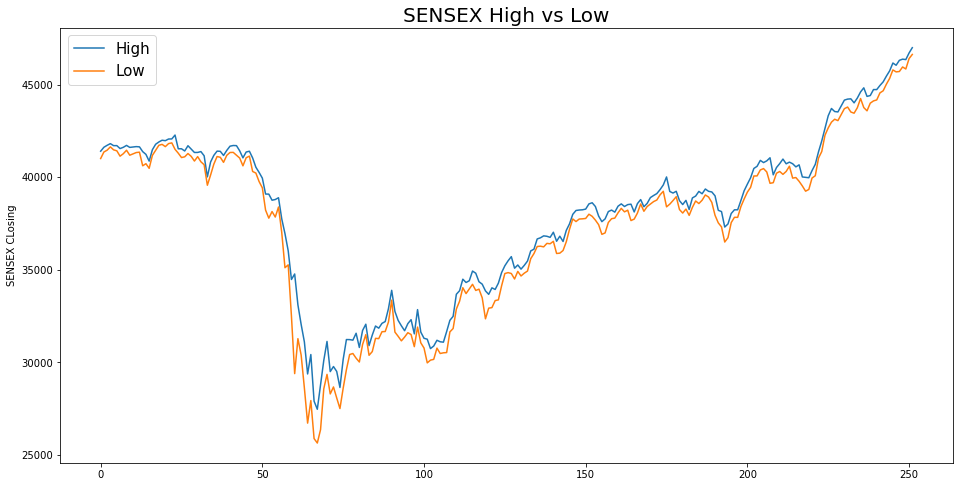

In [29]:
plt.figure(figsize=(16,8))
hisdf["High"].plot()
hisdf["Low"].plot()
plt.legend(fontsize = 15)
plt.ylabel("SENSEX CLosing")
plt.title("SENSEX High vs Low",fontsize = 20)

#### Removing Unnecessary characters

In [30]:
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

## Historical stock price Analysis
#### Let's visualise the Moving Average

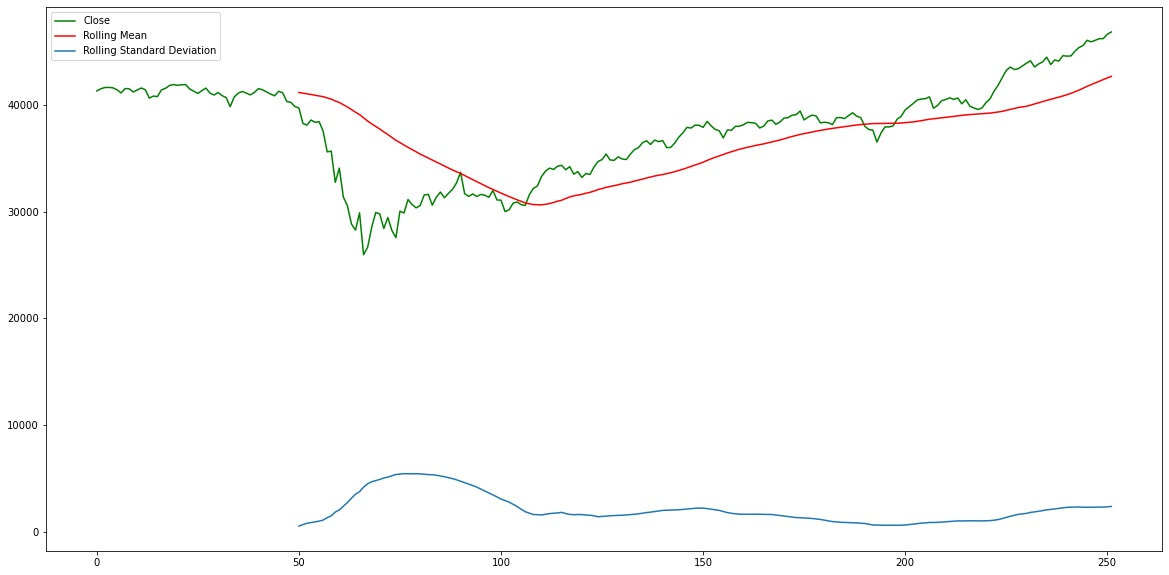

In [31]:
# Plotting moving average
close = hisdf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window =50).std()

plt.figure(figsize=(20,10))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

#### Return Plot

Text(0.5, 1.0, 'Returns')

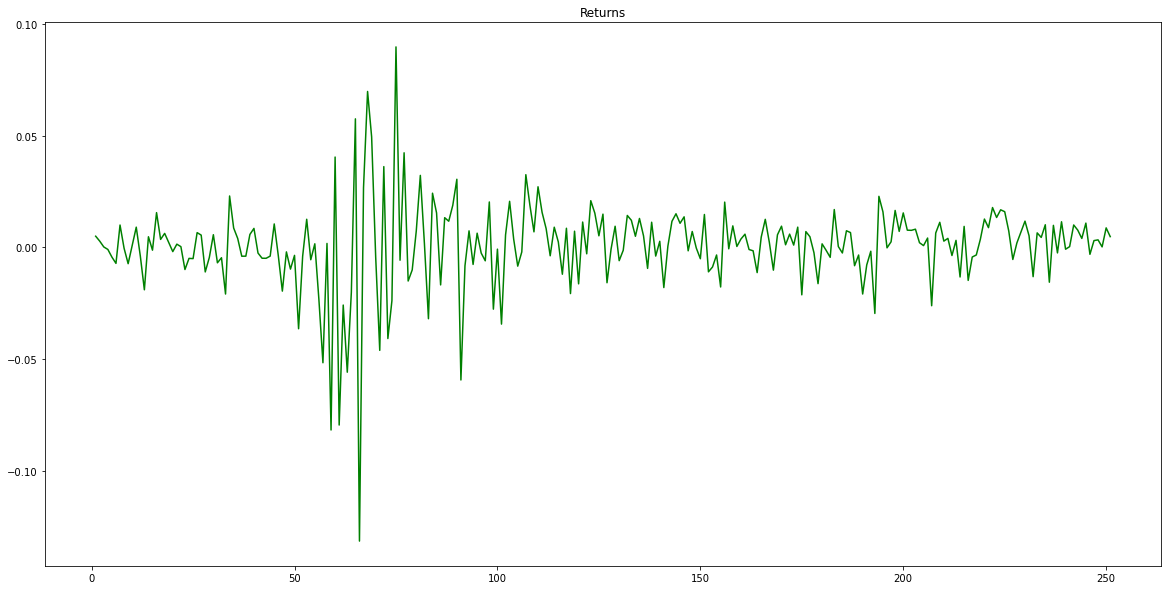

In [32]:
# Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [33]:
# Train test split
train = hisdf[:240]
test = hisdf[240:]

## Stationarity Test
#### Rolling mean and standard deviation

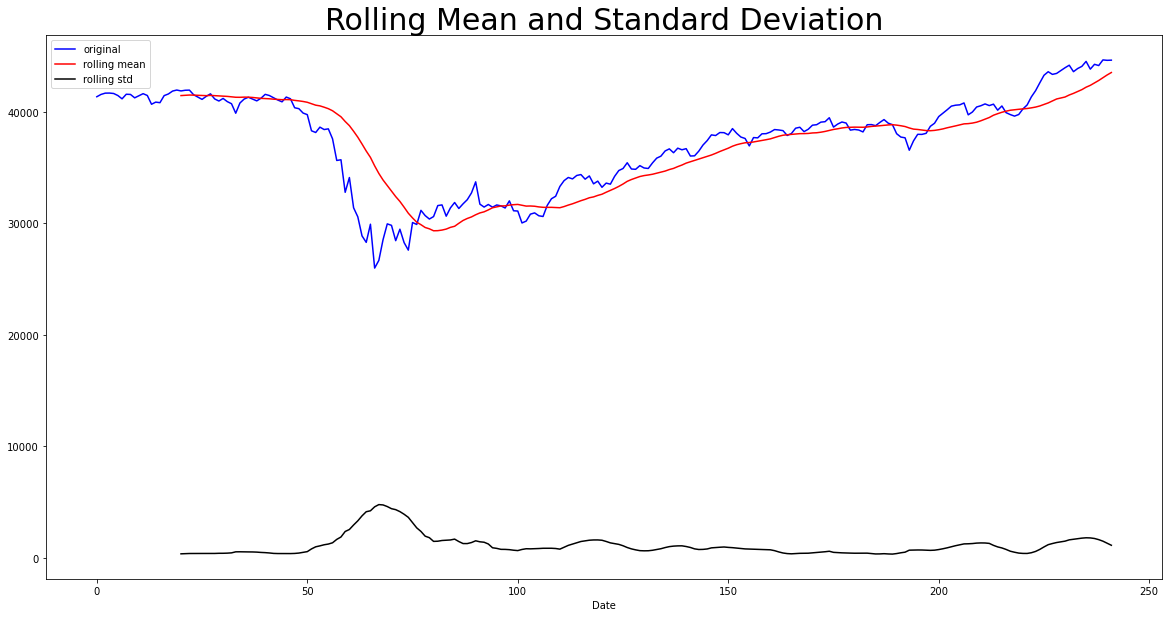

Results of dickey fuller test
ADF Test Statistic : -1.0330833616378603
p-value : 0.7410075195912009
#Lags Used : 6
Number of Observations Used : 233
Weak evidence against null hypothesis, time series is non-stationary 


In [34]:
#Stationarity test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determine the rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    plt.figure(figsize = (20,10))
    plt.plot(timeseries, color = 'blue', label = 'original')
    plt.plot(rolmean, color = 'r', label = 'rolling mean')
    plt.plot(rolstd, color = 'black', label = 'rolling std')
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
    plt.show(block = False)

    print('Results of dickey fuller test')
    result = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series is non-stationary ")

test_stationarity(train['Close'])

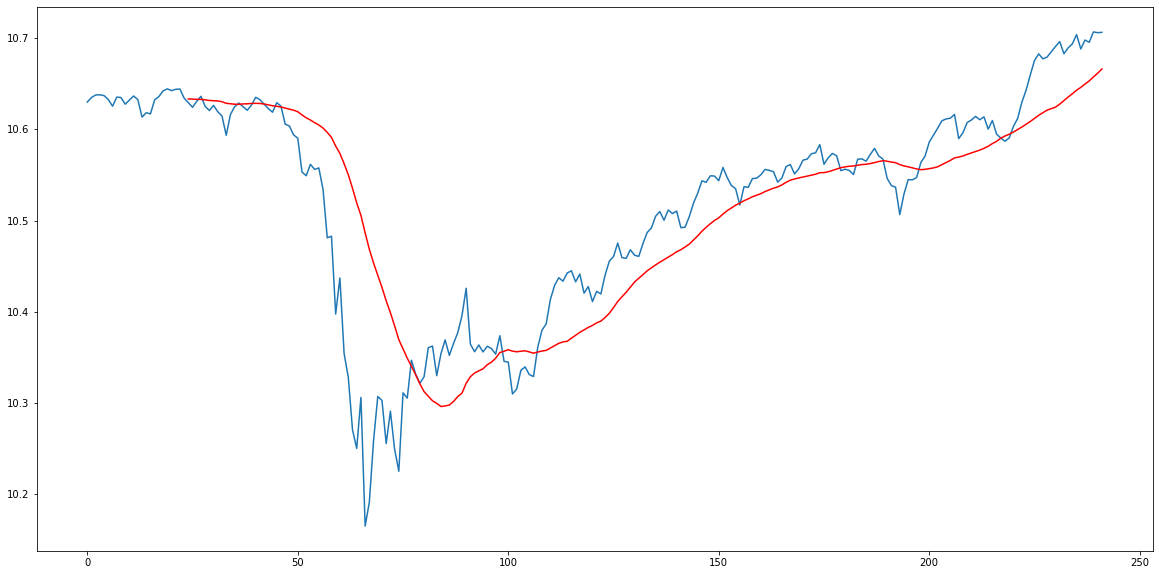

In [35]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (20,10))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

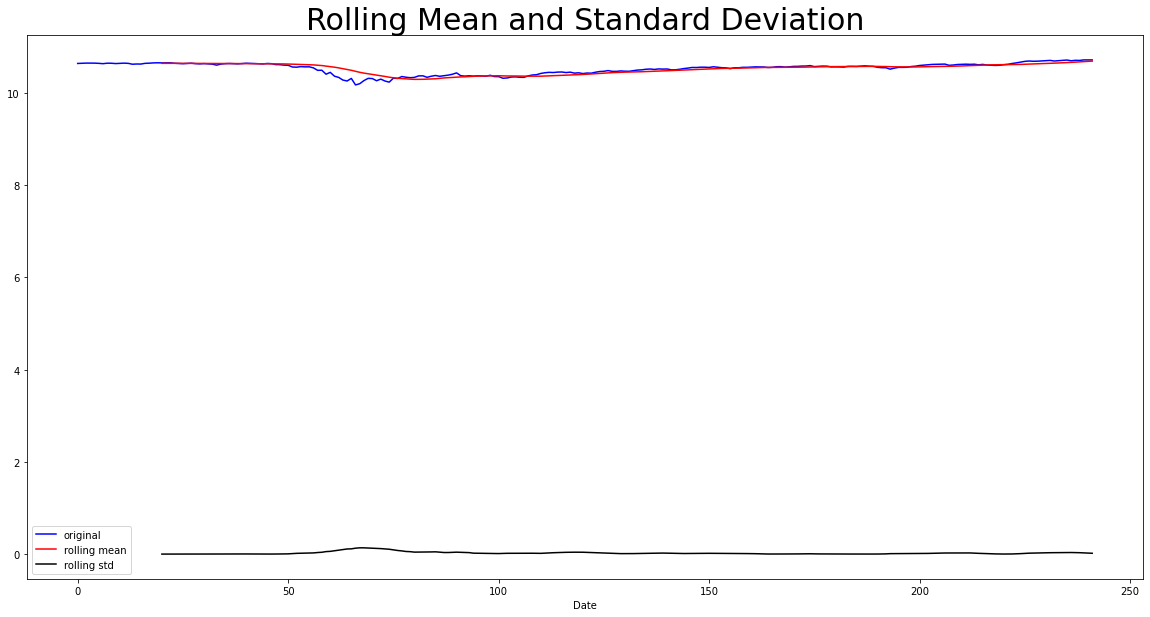

Results of dickey fuller test
ADF Test Statistic : -1.424795014981172
p-value : 0.5703330576099757
#Lags Used : 7
Number of Observations Used : 232
Weak evidence against null hypothesis, time series is non-stationary 


In [36]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

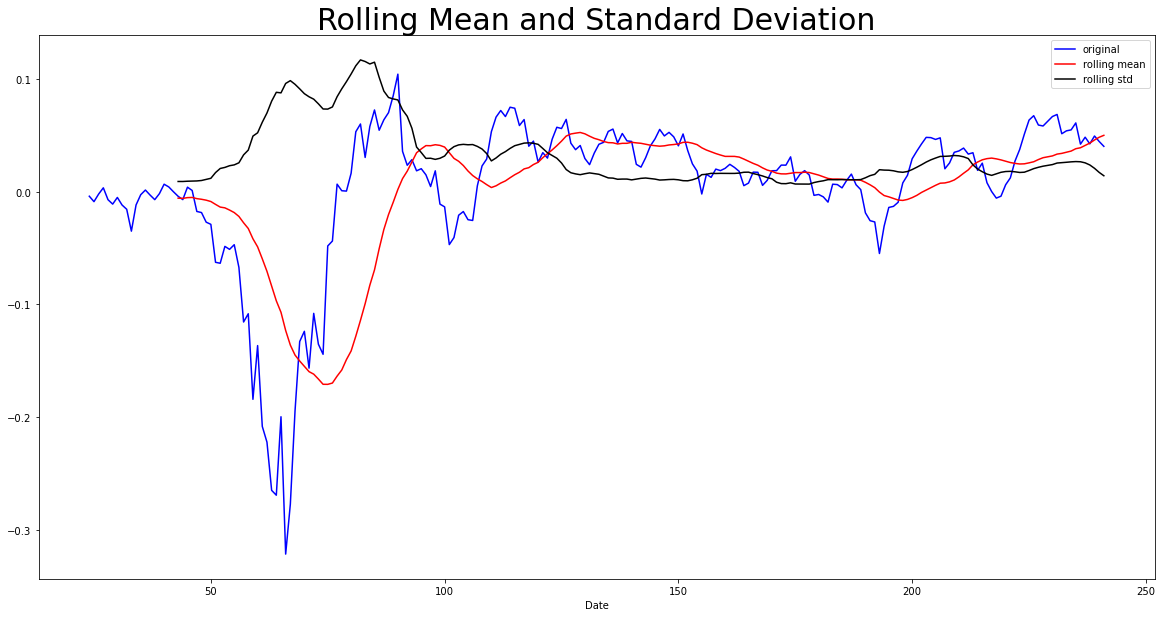

Results of dickey fuller test
ADF Test Statistic : -2.990551689563469
p-value : 0.035786224223079297
#Lags Used : 7
Number of Observations Used : 209
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [37]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

#### Using auto_arima to make the prediction model using log data

In [38]:
from pmdarima import auto_arima

In [39]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
print(predictions.shape)
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1170.483, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1170.211, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1173.055, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1172.498, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1172.155, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1171.515, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1171.240, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1169.662, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1174.981, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1173.446, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1173.167, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1174.424, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1171.595, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.479 seconds
(10,)


Text(0, 0.5, 'Actual Stock Price')

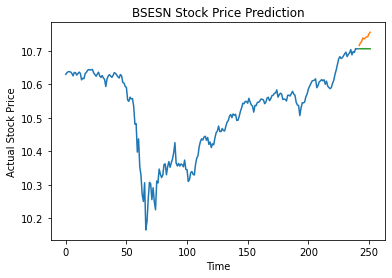

In [40]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

#### Calculating error

In [41]:
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.03292232915413702


## Textual Analysis

In [42]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [43]:
ndf.shape

(7262, 2)

In [44]:
# Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

,date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930


In [45]:
# Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

In [46]:
ndf['Compound'] = [sia.polarity_scores(v)['compound'] for v in ndf['News']]

In [47]:
ndf['Negative'] = [sia.polarity_scores(v)['neg'] for v in ndf['News']]

In [48]:
ndf['Neutral'] = [sia.polarity_scores(v)['neu'] for v in ndf['News']]

In [49]:
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]

In [50]:
ndf

,date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978,-0.9997,0.132,0.787,0.082
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405,-0.9998,0.143,0.758,0.098
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775,-0.9999,0.154,0.748,0.098
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930,-0.9999,0.150,0.764,0.086


#### Merging the two datasets

In [51]:
df_merge = pd.merge(hisdf, ndf, how='inner', on='date')
df_merge

,date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0,After Jagannath Temple Puri beach devpt plan ...,0.356256,0.037977,-1.0000,0.206,0.715,0.079
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0,What is Citizenship Amendment Bill All...,0.396291,0.039680,-0.9999,0.164,0.754,0.082
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0,Only of CCA covered after revamp of canals...,0.371783,0.029115,-0.9998,0.135,0.797,0.068
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0,I'm done playing the good girl I want to be a...,0.366210,0.047456,-0.9999,0.179,0.733,0.088
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0,Weekly Horoscope December Check predic...,0.393635,0.036077,-0.9999,0.157,0.753,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,46099.011719,26300.0,Ways to get you in the mood for sex when you'r...,0.374037,0.052291,-0.9999,0.168,0.743,0.089
246,2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,46253.460938,18400.0,No threat from Covid claims to balance sheets ...,0.382335,0.072333,-0.9996,0.128,0.776,0.095
247,2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,46263.171875,16400.0,RT PCR tests in a day only found ve ...,0.368751,0.039336,-0.9999,0.145,0.767,0.089
248,2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,46666.460938,13100.0,Asmita Sood's favourite holiday destinations a...,0.427681,0.067088,-0.9997,0.124,0.793,0.083


In [52]:
ndf.columns

Index(['date', 'News', 'Subjectivity', 'Polarity', 'Compound', 'Negative',
       'Neutral', 'Positive'],
      dtype='object')

In [53]:
df_merge.shape

(250, 14)

#### Creating Dataframe for model training

In [54]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,41352.171875,0.356256,0.037977,-1.0000,0.206,0.715,0.079
1,41558.570313,0.396291,0.039680,-0.9999,0.164,0.754,0.082
2,41673.921875,0.371783,0.029115,-0.9998,0.135,0.797,0.068
3,41681.539063,0.366210,0.047456,-0.9999,0.179,0.733,0.088
4,41642.660156,0.393635,0.036077,-0.9999,0.157,0.753,0.091
...,...,...,...,...,...,...,...
245,46099.011719,0.374037,0.052291,-0.9999,0.168,0.743,0.089
246,46253.460938,0.382335,0.072333,-0.9996,0.128,0.776,0.095
247,46263.171875,0.368751,0.039336,-0.9999,0.145,0.767,0.089
248,46666.460938,0.427681,0.067088,-0.9997,0.124,0.793,0.083


#### Normalizing data

In [55]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.735131,0.157604,0.254831,0.00000,0.913386,0.044118,0.296296
1,0.745002,0.537627,0.270044,0.00005,0.582677,0.330882,0.333333
2,0.750519,0.304990,0.175669,0.00010,0.354331,0.647059,0.160494
3,0.750884,0.252084,0.339500,0.00005,0.700787,0.176471,0.407407
4,0.749024,0.512408,0.237860,0.00005,0.527559,0.323529,0.444444


In [56]:
df = df.reset_index()
X=df.drop('Close',axis=1)
X

,index,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0,0.157604,0.254831,0.000000,0.913386,0.044118,0.296296
1,1,0.537627,0.270044,0.000050,0.582677,0.330882,0.333333
2,2,0.304990,0.175669,0.000100,0.354331,0.647059,0.160494
3,3,0.252084,0.339500,0.000050,0.700787,0.176471,0.407407
4,4,0.512408,0.237860,0.000050,0.527559,0.323529,0.444444
...,...,...,...,...,...,...,...
245,245,0.326385,0.382691,0.000050,0.614173,0.250000,0.419753
246,246,0.405146,0.561721,0.000201,0.299213,0.492647,0.493827
247,247,0.276208,0.266972,0.000050,0.433071,0.426471,0.419753
248,248,0.835584,0.514876,0.000151,0.267717,0.617647,0.345679


In [57]:
Y=df['Close']
Y

0      0.735131
1      0.745002
2      0.750519
3      0.750884
4      0.749024
         ...   
245    0.962154
246    0.969541
247    0.970005
248    0.989293
249    1.000000
Name: Close, Length: 250, dtype: float64

#### Splitting the dataset

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(200, 7)

### RandomForestRegressor

In [59]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

[0.82832875 0.38620856 0.25958704 0.58720481 0.58255927 0.5792867
 0.5800947  0.24619796 0.1881482  0.57194658]
225    0.842333
122    0.393456
92     0.272824
157    0.576027
154    0.524095
161    0.592488
198    0.621378
83     0.258180
63     0.110334
155    0.559884
Name: Close, dtype: float64
Mean Squared error:  0.0009993535333977562


### DecisionTreeRegressor

In [60]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

[0.83102341 0.35997158 0.26686852 0.58351809 0.59427578 0.58152808
 0.60814721 0.26818374 0.25868307 0.57821183]
225    0.842333
122    0.393456
92     0.272824
157    0.576027
154    0.524095
161    0.592488
198    0.621378
83     0.258180
63     0.110334
155    0.559884
Name: Close, dtype: float64
Mean Squared error:  0.001998096277628719


### AdaBoostRegressor

In [61]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.0015640709098047692


### LGBMRegressor

In [62]:
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)

predictions = gbm.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.001581305681837575


### XGBRegressor

In [63]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.0014005982411840368


## Summary:
* So far trying various models we observe that RandomForestRegressor model is most robust as it's Mean Squared Error is least.

* Many parameters also can be applied to achieve more robustness.